In [2]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [3]:
!pip install wget

path = './drive/My Drive/Stock_price/data/btc_1h'

import numpy as np
import pandas as pd
import wget

# pull some data
url = 'http://www.cryptodatadownload.com/cdd/Coinbase_BTCUSD_1h.csv'
table = wget.download(url)

df = pd.read_csv('Coinbase_BTCUSD_1h.csv', header = 1, index_col = 'Date')
df = df.reindex(index = df.index[::-1])
df = df.drop(columns = ['Symbol', 'Volume BTC'])

In [4]:
df.head()

,Open,High,Low,Close,Volume USD
Date,,,,,
2017-07-01 11-AM,2505.56,2513.38,2495.12,2509.17,287000.32
2017-07-01 12-PM,2509.17,2512.87,2484.99,2488.43,393142.50
2017-07-01 01-PM,2488.43,2488.43,2454.40,2454.43,693254.01
2017-07-01 02-PM,2454.43,2473.93,2450.83,2459.35,712864.80
2017-07-01 03-PM,2459.35,2475.00,2450.00,2467.83,682105.41


In [5]:
df.tail()

,Open,High,Low,Close,Volume USD
Date,,,,,
2019-12-10 10-PM,7220.69,7250.00,7220.68,7237.18,1304465.68
2019-12-10 11-PM,7237.18,7249.66,7219.25,7219.37,1407447.50
2019-12-11 12-AM,7219.37,7241.20,7215.14,7230.04,1165826.61
2019-12-11 01-AM,7230.04,7263.31,7225.28,7263.03,1827764.49
2019-12-11 02-AM,7263.03,7263.28,7245.03,7245.03,152839.00


## Autoregressive Model

In [0]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['Close'].values.reshape(-1, 1)

In [0]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [8]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (21414, 10, 1) Y.shape (21414,)


In [9]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 10707 samples, validate on 10707 samples
Epoch 1/80
10707/10707 [==============================] - 5s 463us/sample - loss: 0.0145 - val_loss: 5.7321e-04
Epoch 2/80
10707/10707 [==============================] - 2s 186us/sample - loss: 0.0022 - val_loss: 5.8187e-04
Epoch 3/80
10707/10707 [==============================] - 2s 181us/sample - loss: 0.0018 - val_loss: 0.0013
Epoch 4/80
10707/10707 [==============================] - 2s 183us/sample - loss: 0.0017 - val_loss: 9.5466e-04
Epoch 5/80
10707/10707 [==============================] - 2s 185us/sample - loss: 0.0023 - val_loss: 0.0014
Epoch 6/80
10707/10707 [==============================] - 2s 187us/sample - loss: 0.0021 - val_loss: 5.2535e-04
Epoch 7/80
10707/10707 [==============================] - 2s 189us/sample - loss: 0.0019 - val_loss: 6.6265e-04
Epoch 8/80
10707/10707 [==============================] - 2s 191us/sample - loss: 0.0018 - val_loss: 6.1045e-04
Epoch 9/80
10707/10707 [==============================] - 2s 1

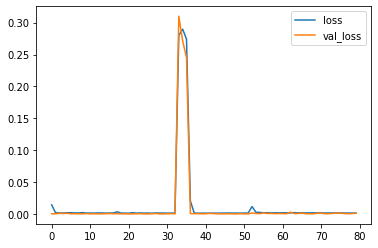

In [10]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(21414, 1)


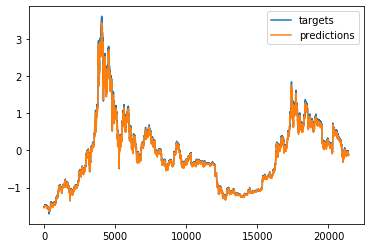

In [11]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

Congratulations, you're a billionaire.

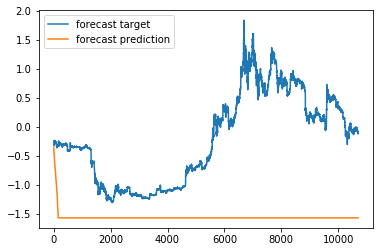

In [12]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

## Returns

In [0]:
# calculate returns by first shifting the data
df['PrevClose'] = df['Close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [5]:
df.head()

,Open,High,Low,Close,Volume USD,PrevClose
Date,,,,,,
2017-07-01 11-AM,2505.56,2513.38,2495.12,2509.17,287000.32,NaN
2017-07-01 12-PM,2509.17,2512.87,2484.99,2488.43,393142.50,2509.17
2017-07-01 01-PM,2488.43,2488.43,2454.40,2454.43,693254.01,2488.43
2017-07-01 02-PM,2454.43,2473.93,2450.83,2459.35,712864.80,2454.43
2017-07-01 03-PM,2459.35,2475.00,2450.00,2467.83,682105.41,2459.35


In [0]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['Close'] - df['PrevClose']) / df['PrevClose']

In [7]:
df.head()

,Open,High,Low,Close,Volume USD,PrevClose,Return
Date,,,,,,,
2017-07-01 11-AM,2505.56,2513.38,2495.12,2509.17,287000.32,NaN,NaN
2017-07-01 12-PM,2509.17,2512.87,2484.99,2488.43,393142.50,2509.17,-0.008266
2017-07-01 01-PM,2488.43,2488.43,2454.40,2454.43,693254.01,2488.43,-0.013663
2017-07-01 02-PM,2454.43,2473.93,2450.83,2459.35,712864.80,2454.43,0.002005
2017-07-01 03-PM,2459.35,2475.00,2450.00,2467.83,682105.41,2459.35,0.003448


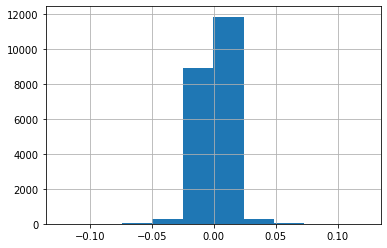

In [8]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [0]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [10]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (21413, 10, 1) Y.shape (21413,)


In [12]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=40,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 10706 samples, validate on 10707 samples
Epoch 1/40
10706/10706 [==============================] - 4s 365us/sample - loss: 1.0024 - val_loss: 0.4674
Epoch 2/40
10706/10706 [==============================] - 2s 187us/sample - loss: 0.9966 - val_loss: 0.4720
Epoch 3/40
10706/10706 [==============================] - 2s 192us/sample - loss: 0.9945 - val_loss: 0.4671
Epoch 4/40
10706/10706 [==============================] - 2s 192us/sample - loss: 0.9927 - val_loss: 0.4665
Epoch 5/40
10706/10706 [==============================] - 2s 193us/sample - loss: 0.9890 - val_loss: 0.4668
Epoch 6/40
10706/10706 [==============================] - 2s 192us/sample - loss: 0.9869 - val_loss: 0.4687
Epoch 7/40
10706/10706 [==============================] - 2s 191us/sample - loss: 0.9840 - val_loss: 0.4676
Epoch 8/40
10706/10706 [==============================] - 2s 194us/sample - loss: 0.9809 - val_loss: 0.4686
Epoch 9/40
10706/10706 [==============================] - 2s 187us/sample - loss: 0.98

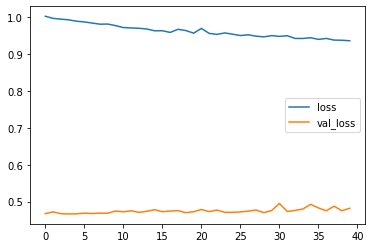

In [13]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(21413, 1)


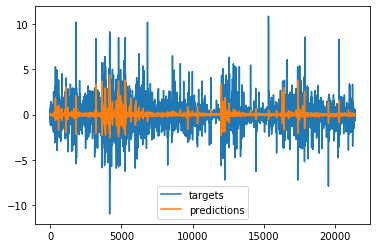

In [14]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

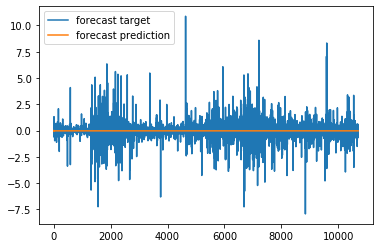

In [15]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

## Classification

In [0]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['Open', 'High', 'Low', 'Close', 'Volume USD']].values
targets = df['Return'].values

In [0]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [0]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [0]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [0]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [0]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [23]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=50,
  validation_data=(X_test, Y_test),
)

Train on 14282 samples, validate on 7132 samples
Epoch 1/50
14282/14282 [==============================] - 3s 179us/sample - loss: 0.6919 - accuracy: 0.5179 - val_loss: 0.6932 - val_accuracy: 0.5129
Epoch 2/50
14282/14282 [==============================] - 3s 181us/sample - loss: 0.6920 - accuracy: 0.5167 - val_loss: 0.6942 - val_accuracy: 0.5049
Epoch 3/50
14282/14282 [==============================] - 2s 173us/sample - loss: 0.6918 - accuracy: 0.5152 - val_loss: 0.6942 - val_accuracy: 0.5039
Epoch 4/50
14282/14282 [==============================] - 3s 180us/sample - loss: 0.6919 - accuracy: 0.5153 - val_loss: 0.6933 - val_accuracy: 0.5130
Epoch 5/50
14282/14282 [==============================] - 3s 182us/sample - loss: 0.6916 - accuracy: 0.5165 - val_loss: 0.6937 - val_accuracy: 0.5100
Epoch 6/50
14282/14282 [==============================] - 3s 186us/sample - loss: 0.6911 - accuracy: 0.5181 - val_loss: 0.6939 - val_accuracy: 0.5149
Epoch 7/50
14282/14282 [===========================

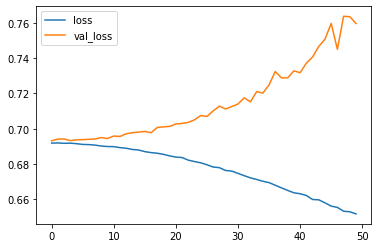

In [24]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

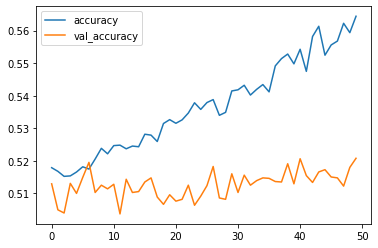

In [25]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

Clearly overfitting and not better than random.